In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import figure
from scipy.spatial.distance import euclidean as eu
import math
from scipy import signal

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
 
import Data_load as dl
import Print_statements as ps
import length_based_confusion_mat as c_mat
import binning as bn

In [2]:
feature_list=['LX', 'LY', 'RX', 'RY']
C_data, D_data = dl.get_data()

### Getting binning results:

In [3]:
conf_l, conf, a, binned = bn.kmeans_binning(D_data,C_data, 1000, 10)

## Next approaches:
### 1. Sectional K-means:
1. Broke down the binned vector into different sections based on frequency values. Eg. First 5, next 5 and so on. 
2. Applied K-means on each section separately and recorded their accuracy. Eg. Taking 25 bins in each section we get the following accuracy distribution. 
3. The idea was to check which part of the freq spectrum gave better accuracy. 


In [4]:
sec_len, sec_mat, sec_acc = bn.sectional_kmeans(25, binned)

The funciton gives the following outputs:
1. all_sec_len - gives the length wise confusion matrix for each section.
2. all_sec_mat - gives the confusion matrix for each section.
3. all_sec_acc - accuracy values for each section. 

Focusing on the sectional accuracy:


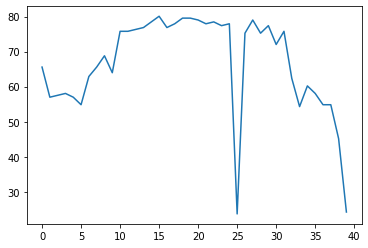

In [5]:
plt.plot(sec_acc)

This plot shows that the 10th-24th and 26th-32th sections of the distribution are better for K-means classification of the data data we've got. 

### 2. PCA (weighing approach):

1. Used PCA to find principal components.

In [6]:
binned = np.delete(binned, 999, 1)
x = StandardScaler().fit_transform(binned)

In [7]:
pca = PCA(n_components=186)
principalComponents = pca.fit_transform(x)

Oberving the variations captured by the different principal components:

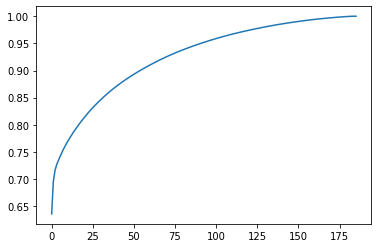

In [8]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

2. The first component was able to capture variability up to 63.57%.
3. Found the co-relation of each dimension with the first component. Weighed each dimension based on the co-relation score. Co-relation scores:

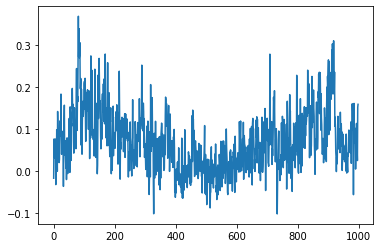

In [9]:
import PCA_funcs as pcaf

corr_vals = pcaf.corr(binned, principalComponents)
plt.plot(corr_vals)

In [10]:
wtd_bins = pcaf.apply_wts(corr_vals, binned)

4. Applied K-means based on weighted dimensions. Result - 72.58%


In [11]:
kmeans = KMeans(n_clusters = 2, random_state=0).fit(binned)

predicted_labels = kmeans.labels_
actual_labels = np.concatenate((np.ones(98), np.zeros(88)))

accuracy_score(actual_labels,predicted_labels)*100

69.35483870967742

The idea was to understand which dimensions captured the variability more than other and so could be relied on. Weighing them based on this metric was to give more importance to the once would be more helpful in differentiating the 2 types of candidates.

## 3. Converting data based on Principal Components:


In [12]:
pca_conv = pca.transform(binned)

In [13]:
kmeans = KMeans(n_clusters = 2, random_state=0).fit(pca_conv)

predicted_labels = kmeans.labels_
actual_labels = np.concatenate((np.ones(98), np.zeros(88)))

100 - accuracy_score(actual_labels,predicted_labels)*100 #normal accuracy was less than 50

73.65591397849462

## Visualizing distances of different vectors(after converting based on PCA) from Cluster Centers

To visualize which vectors are correctly or wrongly classified and the degree to which they are correctly or wrongly classified.

1.Calculating distances of each vector from the Cluster Centers 

In [14]:
centers = kmeans.cluster_centers_

distances = pcaf.distance_from_cluster_center(centers, pca_conv)

The function gives us the distance from:
1. The first cluster center
2. The second cluster center
3. The closest cluster center

The difference between the distances from each cluster center can be used as a metric to access how well the particular vector is classified. For an ideal separation most of the vectors will be much more closer to the correct cluster center than the other cluster centers. 
    
Calculating the degree of classification based on the mention matric for the correctly and wrongly classified vectors separately

In [15]:
cor_clas, wr_clas = pcaf.degree_of_classification(distances, actual_labels, predicted_labels)

Plotting according to serial number and in ascending order:

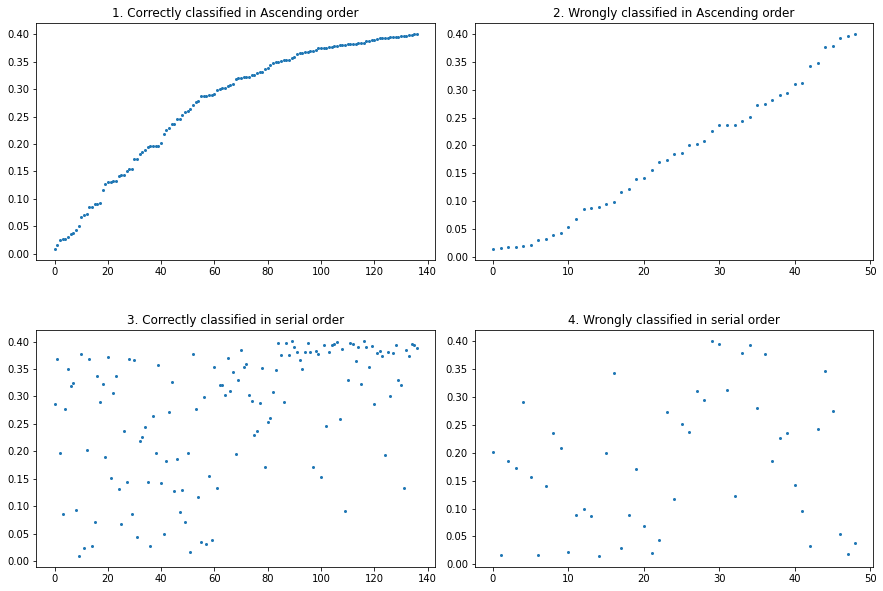

In [16]:
pcaf.plot_degree(cor_clas, wr_clas)

1. For the vectors which are correctly classified:
    1. If the difference is high: this means that the classification is correct to a higher degree. As this would mean that it's distance from the correct cluster is much lass than the other center. This corresponds to the top right of the first graph. 
    2. If the differnce is low: this means that the classification is correct but to a lower degree. This is the case where the vector is very close to the hyperplane separating the two clusters. This corresponds to the bottom left of the second graph. 
2. For vectors which are wrongly classified:
    1. If the difference is high: this means that the classification is wrong and that to at a very high degree. Here the vector is much closer to the wrong cluster center as compared to the correct cluster center. This is an indication of being highly misclassified. This corresponds to the top right of the second graph. 
    2. If the difference is low: this means that the clasification is wrong but to a lower degree. This is the case of the vector being very close to the separating hyper plane. This corresponds to the bottom left of the second graph. 